## Visualizing Nearest Neighbors as a Network

We can take the results of the nearest neighbors clustering in the [Find Similar Images notebook](find-similar-images.ipynb) and represent those relationships as a kind of network graph, where each node will have a weighted directed link to its five nearest neighbors. Then, we can filter that graph to show just the strongest of such relationships. This gives us a graph that we might interpret as showing the _flow_ of visual influence.

First thing we do is convert the .json files in the `nearest_neighbors` folder into a single CSV file arranged in three columns, source, target, and weight. The code that we'll use was written by Iain Davidson. 

In [1]:
import json 
import csv 
import os

directory = "nearest_neighbors/"
  
# setup csv
data_file = open('data_file.csv', 'w') 
  
# create the csv writer object 
csv_writer = csv.writer(data_file) 
  

for filename in os.listdir(directory): 
	temp = None
	# Opening JSON file
	with open(directory+"/"+filename) as json_file: 
		data = json.load(json_file) 
	  
	for entry in data: 
		if temp == None:
			temp = entry["filename"]
		# Writing data of CSV file 
		if entry.values():
			a = list(entry.values())
			a.insert(0,temp)
			csv_writer.writerow(a)
  
data_file.close() 

## A quick look at the result, and a slight addition 

Go look at the resulting file, 'data_file.csv'. Insert a row at the start of the file with `source,target,weight`.

Notice also that there are rows there where the source and target are the same, and the weight is `1.0`. An image compared against itself is going to be identical, right? We'll eventually want to filter those edges (rows in this csv, which is really a table of relationships, or 'edgelist') out.


Now we'll add the package 'networkx' so we can graph this network, and 'pandas' so we can manipulate the data, and matplotlib so we can draw the graphs.

In [8]:
!pip install networkx
!pip install pandas
!pip install matplotlib

     |████████████████████████████████| 11.5 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 50.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 41.4 MB/s eta 0:00:01


We now read the data in, and then create a graph object into which we will put that data, telling it that we're dealing with an edgelist and the weight of those edges (the strength of the relationships) is in the 'weight' column

In [5]:
import networkx as nx
import pandas as pd

df = pd.read_csv('data_file.csv')
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(df, edge_attr='weight', create_using=Graphtype)

We can draw the graph with this call:

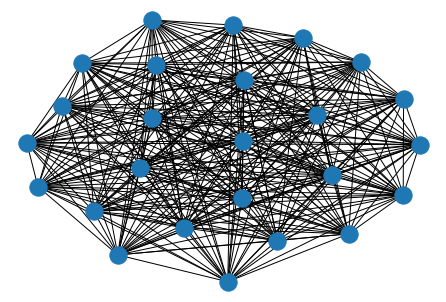

In [9]:
nx.draw(G)

But as you can see, that's a pretty messy graph; every node is connected to every other node because we compared every image to every other image. So we need to filter by edge weight. Let's start by getting rid of the edges that weigh `1.0`

In [27]:
G2=nx.Graph( [ (u,v,d) for u,v,d in G.edges(data=True) if d
['weight']<1.0] )

That got rid of the edges weighted `1.0`. Now, go look at the data and decide what the lower cutoff should be. In the example below, I went with `0.7`. Note also the flow: we created a graph G, then filtered G to create a new graph G2, then filtered _that_ to create a final graph G3.

In [28]:
G3=nx.Graph( [ (u,v,d) for u,v,d in G2.edges(data=True) if d
['weight']>0.7] )

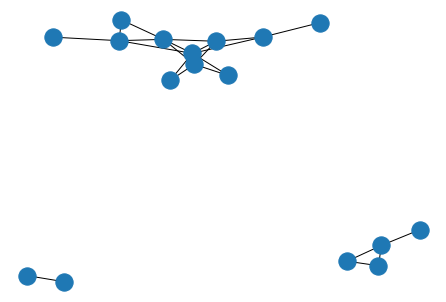

In [30]:
nx.draw(G3)

So judging by this, it looks like we've got three clumps of images where there are interesting similarities happening. Networkx has functions for calculating various metrics, and so on. Let's run some.

In [32]:
nx.betweenness_centrality(G3)

{3969613: 0.0,
 3969615: 0.09027777777777775,
 3969575: 0.05972222222222221,
 3969595: 0.17638888888888885,
 3969585: 0.0,
 3969573: 0.02222222222222222,
 3969597: 0.02638888888888889,
 3969589: 0.0,
 3969581: 0.0,
 3969583: 0.075,
 3969579: 0.0,
 1615157: 0.016666666666666666,
 3969593: 0.0,
 1952272: 0.0,
 3969599: 0.0,
 3969601: 0.0,
 3969591: 0.0}

Now, you might be more familiar or comfortable with something like [Gephi](https://gephi.org). So let's write the graph to the graphml format, which you can then import into gephi or some other package.

In [35]:
nx.write_graphml(G3, "g3.graphml")